In [1]:
import random
import os
import matplotlib.pyplot as plt
import keras
import numpy as np
from keras.models import Input, Model, load_model,Sequential
from keras.layers import LSTM, Dropout, Dense, Flatten, Bidirectional, Embedding, GRU
from keras.optimizers import Adam
import keras.utils as ku 
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


### 定义Config

In [2]:
class Config(object):
    poetry_file = './Datasets/poetry_7_1_(wufuhao).txt' # 训练数据
    weight_file = './model/GRU+LSTM_wufuhao.h5' # 模型存储
    max_len = 6
    batch_size = 32
    learning_rate = 0.001 # 学习率
    epoch = 100


### 处理数据

In [3]:
puncs = [']', '[', '（', '）', '{', '}', '：', '《', '》'] # 将数据中的一些中文符号去除

# 处理数据
def preprocess_file(Config):
    
    files_content = ''
    with open(Config.poetry_file, 'r', encoding='utf-8') as f:
        for line in f:
            # 每行的末尾加上"]"符号代表一首诗结束
            for char in puncs:
                line = line.replace(char, "") # 处理无关的字符
            files_content += line.strip()+"\n" # 去除一行中首尾的空格符

    words = sorted(list(files_content)) # 获取语料文本中的字符
#     words.remove(']')
    # 获得词频
    counted_words = {}
    for word in words:
        if word in counted_words:
            counted_words[word] += 1
        else:
            counted_words[word] = 1

    # 去掉低频的字
    erase = []
    for key in counted_words:
        if counted_words[key] <= 2:
            erase.append(key)
#     for key in erase:
#         del counted_words[key]
    wordPairs = sorted(counted_words.items(), key=lambda x: -x[1]) #排序
#     wordPairs.insert(0,('mask','0'))
    words, _ = zip(*wordPairs) #zip() 函数用于将可迭代的对象作为参数，将对象中对应的元素打包成一个个元组，然后返回由这些元组组成的列表。
    # word到id的映射
    #enumerate() 函数用于将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标
    word2num = dict((c, i) for i, c in enumerate(words))
    num2word = dict((i, c) for i, c in enumerate(words))
    word2numF = lambda x: word2num.get(x, 0) # 函数
    return word2numF, num2word, words, files_content


### 搭建模型

In [4]:
class PoetryModel(object):

    def __init__(self, config):
        self.model = None
        self.do_train = True
        self.loaded_model = False
        self.config = config
        self.predictors = None
        self.label = None
        self.history = None

        # 文件预处理
        self.word2numF, self.num2word, self.words, self.files_content = preprocess_file(
            self.config)
        self.dataset_preparation()
        # 如果模型文件存在则直接加载模型，否则开始训练
        if os.path.exists(self.config.weight_file):
            self.model = load_model(self.config.weight_file)
            self.model.summary()
        else:
            self.train()
        self.do_train = False
        self.loaded_model = True
        
        
    def sequences2numF(self,text):
        token_list = []
        for item in text:
            token_list.append(self.word2numF(item))
        return token_list
    
    def dataset_preparation(self):
        corpus = self.files_content.split("\n")
        print(corpus[0])
        total_words = len(self.num2word) + 1
        # create input sequences using list of tokens
        input_sequences = []
        for line in corpus:
            token_list = self.sequences2numF(line)
            for i in range(1, len(token_list)):
                n_gram_sequence = token_list[:i+1]
                input_sequences.append(n_gram_sequence)
 
        self.config.max_len = max([len(x) for x in input_sequences])
        print(self.config.max_len)
        input_sequences = np.array(pad_sequences(input_sequences, maxlen=self.config.max_len, padding='pre'))
        print("00")
        # create predictors and label
        self.predictors, self.label = input_sequences[:,:-1],input_sequences[:,-1] #最后一个token为lable, 前面为predictor
        self.label = ku.to_categorical(self.label, num_classes=total_words)

    def build_model(self):
        '''建立模型'''
        self.model = Sequential() 
        self.model.add(Embedding(input_dim = len(self.num2word) + 2, output_dim = 300,input_length=self.config.max_len-1))
        self.model.add(Bidirectional(GRU(128, return_sequences=True))) # GRU LSTM 变体 
        self.model.add(LSTM(128))
#         self.model.add(Dropout(0.3))
#         self.model.add(Flatten())
        self.model.add(Dense(len(self.words)+1, activation='softmax'))
        optimizer = Adam(lr=self.config.learning_rate)
        self.model.compile(loss='categorical_crossentropy',
                           optimizer=optimizer, metrics=['accuracy'])

    # 根据给出的文字，生成诗句，需要给出后面预测的字数
    def generate_text(self, send_text,next_words):
        if not self.loaded_model:
            return
        
        for _ in range(next_words):
            token_list = self.sequences2numF(send_text)
            token_list = pad_sequences([token_list], maxlen=self.config.max_len-1, padding='pre')
            predicted = self.model.predict_classes(token_list, verbose=0)
#             print(predicted)
            output_word = self.num2word.get(predicted[0])
            send_text += output_word
        return send_text
    
    # 根据给出的文字，生成藏头诗
    def generate_CTS(self, send_text):
        if not self.loaded_model:
            return
        
        for item in send_text:
            print (self.generate_text(item, 6)) 
            print()
           
    def train(self):
        '''训练模型'''
        number_of_epoch = self.config.epoch
        if not self.model:
            self.build_model()

        self.model.summary()
        self.history = self.model.fit(self.predictors, self.label,epochs=number_of_epoch,verbose=1,batch_size=self.config.batch_size)
        
    def show(self):
        plt.plot(self.history.history['loss'],label = 'train_loss')
        plt.title('loss')
        plt.legend()
        plt.show()

        plt.plot(self.history.history['accuracy'], label='training_accuracy')
        plt.title('Accuracy')
        plt.legend()
        plt.show()


In [5]:
model = PoetryModel(Config)

仓储十万发关中
7
00
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 6, 300)            1369800   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 6, 256)            329472    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_1 (Dense)              (None, 4565)              588885    
Total params: 2,485,277
Trainable params: 2,485,277
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
60000/60000 [==============================] - 37s 613us/step - loss: 7.5265 - accuracy: 0.0068
Epoch 2/100
60000/60000 [==============================] - 35s 582us/step - loss: 7.2731 - accuracy: 0.0109
Epoch 3/100
60000/60000 [==============================] - 35s 583us/step - loss: 7.0199 - accuracy: 0.0169
Epoch 4/100
60000/60000 [==============================] - 35s 584us/step - loss: 6.7091 - accuracy: 0.0268
Epoch 5/100
60000/60000 [==============================] - 35s 583us/step - loss: 6.3800 - accuracy: 0.0398
Epoch 6/100
60000/60000 [==============================] - 35s 585us/step - loss: 6.0516 - accuracy: 0.0551
Epoch 7/100
60000/60000 [==============================] - 35s 582us/step - loss: 5.7271 - accuracy: 0.0764
Epoch 8/100
60000/60000 [==============================] - 35s 582us/step - loss: 5.4143 - accuracy: 0.1017
Epoch 9/100
60000/60000 [==============================] - 35s 584us/step - loss: 5.1135 - accuracy: 0.1320
Epoch 10/100
60000/60000 [==

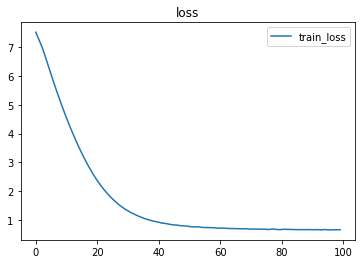

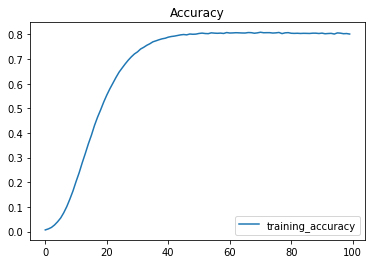

In [6]:
model.show()

In [7]:
## 扩展诗句
text = "君子"
num =  20
sentence = model.generate_text(text,num)
print(sentence)

君子呼澜带壑龄豪僮猱泊手洛小修甘掌柏阴鸾撼静


In [8]:
## 藏头诗
text = "自然语言处理"
sentence = model.generate_CTS(text)

自是圣朝恩泽溥

然明未必都相识

语经重译总差讹

言语不须愁鴂舌

处己谦虚世莫京

理有小异分毫芒



In [9]:
model.model.save(model.config.weight_file)